# Land Type Classification (Sentinel-2, 13 Bands)
## Model Performance Evaluation, Robustness Testing & Confidence Analysis

This notebook evaluates two trained deep learning models:

- **CNN_V2 (13-band convolutional network)**
- **VGG16_V2 (13-band VGG16-based model)**

Both models were trained on the **EuroSAT/all** dataset (Sentinel-2, 13 spectral bands)


This notebook focuses on:
- Evaluating model accuracy on the test set  
- Visual inspection of predictions  
- Confidence intervals for model performance  
- Robustness testing using repeated 1000-sample subsets  
- Comparing CNN vs VGG16 stability  


## 1. Import Required Libraries

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


2025-11-30 03:01:21.756903: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Load EuroSAT (13-Band) Dataset
We use the **EuroSAT/all** dataset, which contains Sentinel-2 imagery with **13 spectral bands**.  

We split the dataset as follows:
- 80% training  
- 10% validation  
- 10% testing  

In this notebook, we only use the **test set** for evaluation.

In [3]:
IMG_SIZE_V2 = 64
BATCH_SIZE_V2 = 64
AUTOTUNE_V2 = tf.data.AUTOTUNE

ds_v2, info_v2 = tfds.load("eurosat/all", with_info=True, as_supervised=True)

DS_FULL_V2 = ds_v2["train"]
NUM_EXAMPLES_V2 = info_v2.splits["train"].num_examples
NUM_CLASSES_V2 = info_v2.features["label"].num_classes
CLASS_NAMES_V2 = info_v2.features["label"].names

TRAIN_SIZE_V2 = int(0.8 * NUM_EXAMPLES_V2)
VAL_SIZE_V2   = int(0.1 * NUM_EXAMPLES_V2)
TEST_SIZE_V2  = NUM_EXAMPLES_V2 - TRAIN_SIZE_V2 - VAL_SIZE_V2

TRAIN_DS_V2 = DS_FULL_V2.take(TRAIN_SIZE_V2)
TEMP_DS_V2  = DS_FULL_V2.skip(TRAIN_SIZE_V2)

VAL_DS_V2  = TEMP_DS_V2.take(VAL_SIZE_V2)
TEST_DS_V2 = TEMP_DS_V2.skip(VAL_SIZE_V2)

print("TRAIN_V2:", TRAIN_SIZE_V2, "VAL_V2:", VAL_SIZE_V2, "TEST_V2:", TEST_SIZE_V2)
print("Classes:", CLASS_NAMES_V2)


I0000 00:00:1764464536.142602    7525 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


TRAIN_V2: 21600 VAL_V2: 2700 TEST_V2: 2700
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## 3. Preprocessing Function (Per-Image Normalization)

The original models were trained using the following preprocessing steps:

1. Resize input to **64×64**
2. Convert to `float32`
3. Apply **per-image, per-band min–max normalization**

In [4]:
def preprocess_v2(image, label):
    image = tf.image.resize(image, (IMG_SIZE_V2, IMG_SIZE_V2))
    image = tf.cast(image, tf.float32)

    # per-image, per-channel min-max normalization
    min_v = tf.reduce_min(image, axis=[0, 1], keepdims=True)
    max_v = tf.reduce_max(image, axis=[0, 1], keepdims=True)
    image = (image - min_v) / (max_v - min_v + 1e-8)

    return image, label


## 4. Prepare the Normalized Test Dataset

In [5]:

TEST_DS_NORM_V2 = (
    TEST_DS_V2
        .map(preprocess_v2, AUTOTUNE_V2)
        .batch(BATCH_SIZE_V2)
        .prefetch(AUTOTUNE_V2)
)


## 5. Load Trained Models (CNN_V2 and VGG16_V2)


In [6]:
CNN_V2_MODEL = keras.models.load_model("MODEL_CNN_13BANDS_V2.keras")
VGG16_V2_MODEL = keras.models.load_model("MODEL_VGG16_13BANDS_V2.keras")

print("Models loaded:")

2025-11-30 03:02:38.638374: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 9437184 exceeds 10% of free system memory.
2025-11-30 03:02:38.793547: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 9437184 exceeds 10% of free system memory.


Models loaded:


## 6. Convert Test Dataset to NumPy Arrays

In [10]:
X_TEST = []
Y_TEST = []

for x_batch, y_batch in TEST_DS_NORM_V2:
    X_TEST.append(x_batch.numpy())
    Y_TEST.append(y_batch.numpy())

X_TEST = np.concatenate(X_TEST, axis=0)  # shape: (N, 64, 64, 13)
Y_TEST = np.concatenate(Y_TEST, axis=0)  # shape: (N,)

print("X_TEST shape:", X_TEST.shape)
print("Y_TEST shape:", Y_TEST.shape)


2025-11-30 03:06:03.566780: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-30 03:06:46.229914: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_TEST shape: (2700, 64, 64, 13)
Y_TEST shape: (2700,)


## 7.Evaluation


In [8]:
def accuracy_confidence_interval(acc, n, alpha=0.05):
    """
    Normal approximation 95% CI for accuracy.
    acc: accuracy (0–1), n: number of samples
    """
    import math
    z = 1.96  # for 95% CI
    se = math.sqrt(acc * (1 - acc) / n)
    lower = acc - z * se
    upper = acc + z * se
    return max(0.0, lower), min(1.0, upper)


def show_random_predictions(model, model_name, X, y, class_names, n_samples=16, seed=None):
    """
    - Take n_samples random examples from (X, y)
    - Show predictions in a grid
    - Compute accuracy and 95% CI on that sample
    """
    rng = np.random.default_rng(seed)
    N = X.shape[0]
    indices = rng.choice(N, size=n_samples, replace=False)

    X_sub = X[indices]
    y_sub = y[indices]

    # model predictions
    preds = model.predict(X_sub, verbose=0)  
    y_pred = np.argmax(preds, axis=1)
    confidences = np.max(preds, axis=1) 

    # accuracy on this subset
    acc = accuracy_score(y_sub, y_pred)
    ci_low, ci_high = accuracy_confidence_interval(acc, n_samples)

    print(f"\n{model_name} — Random sample of {n_samples} images")
    print(f"Sample accuracy: {acc:.4f}")
    print(f"95% CI for accuracy on this sample: [{ci_low:.4f}, {ci_high:.4f}]")

    # plot grid
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))

    for i, idx in enumerate(indices):
        ax = plt.subplot(n_rows, n_cols, i + 1)

        # for visualization: show first 3 bands as RGB-like (not real RGB)
        img = X[idx, :, :, :3]  # take 3 of the 13 channels
        img_disp = (img - img.min()) / (img.max() - img.min() + 1e-8)

        ax.imshow(img_disp)
        true_label = class_names[y[idx]]
        pred_label = class_names[y_pred[i]]
        conf = confidences[i]

        ax.set_title(f"T: {true_label}\nP: {pred_label}\nConf: {conf:.2f}")
        ax.axis("off")

    plt.suptitle(f"{model_name} — Random Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

    return acc, (ci_low, ci_high)


## 8. Random Predictions: Visual INspection + Confidence Interval


2025-11-30 03:08:05.583368: I external/local_xla/xla/service/service.cc:163] XLA service 0x78c46c0054f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-30 03:08:05.583666: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-30 03:08:05.770098: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-30 03:08:06.368672: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
I0000 00:00:1764464890.999207    7790 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



CNN_V2 (13-BANDS) — Random sample of 16 images
Sample accuracy: 0.9375
95% CI for accuracy on this sample: [0.8189, 1.0000]


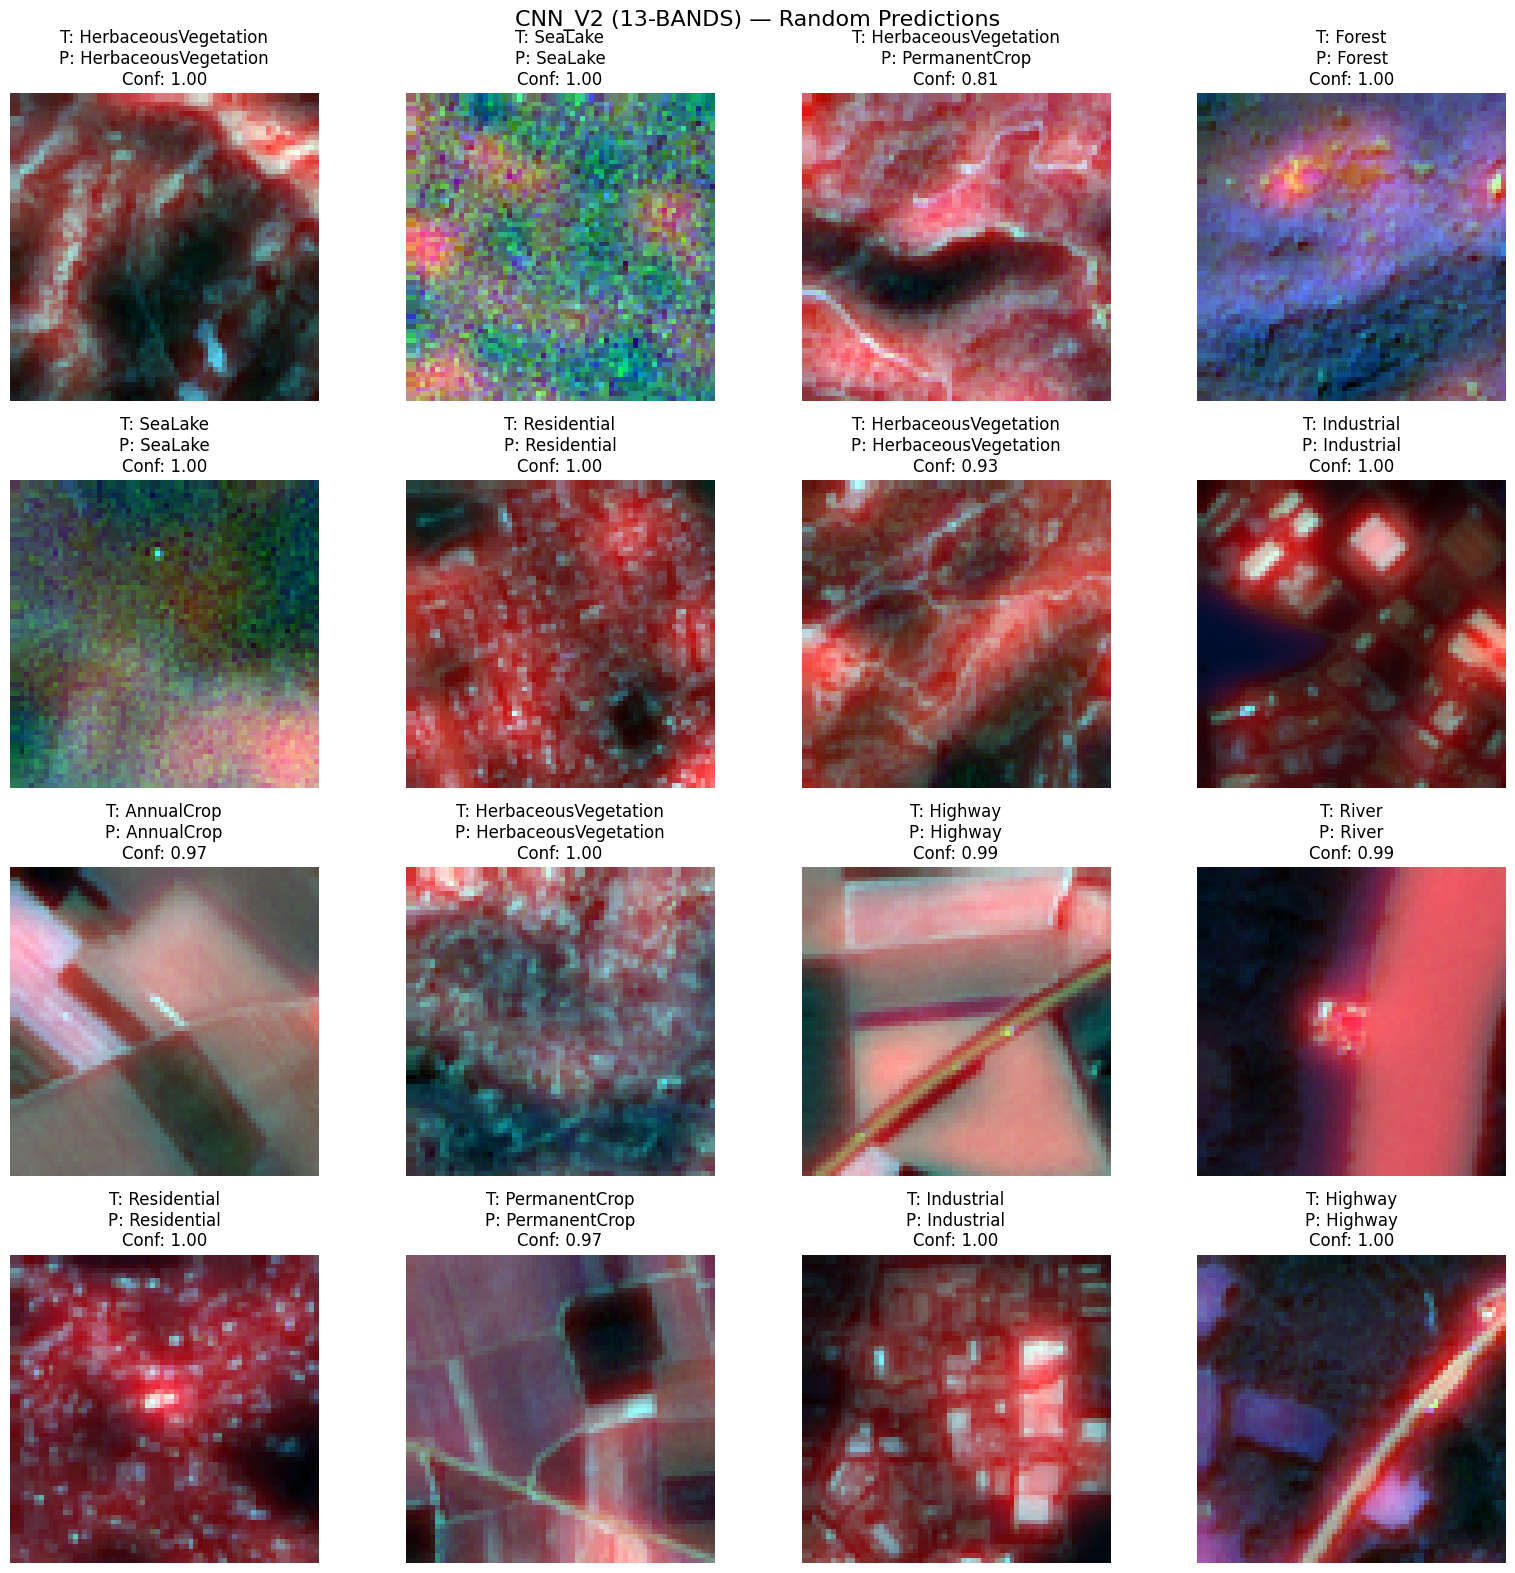

2025-11-30 03:08:20.611590: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_209', 12 bytes spill stores, 12 bytes spill loads




VGG16_V2 (13-BANDS) — Random sample of 16 images
Sample accuracy: 0.9375
95% CI for accuracy on this sample: [0.8189, 1.0000]


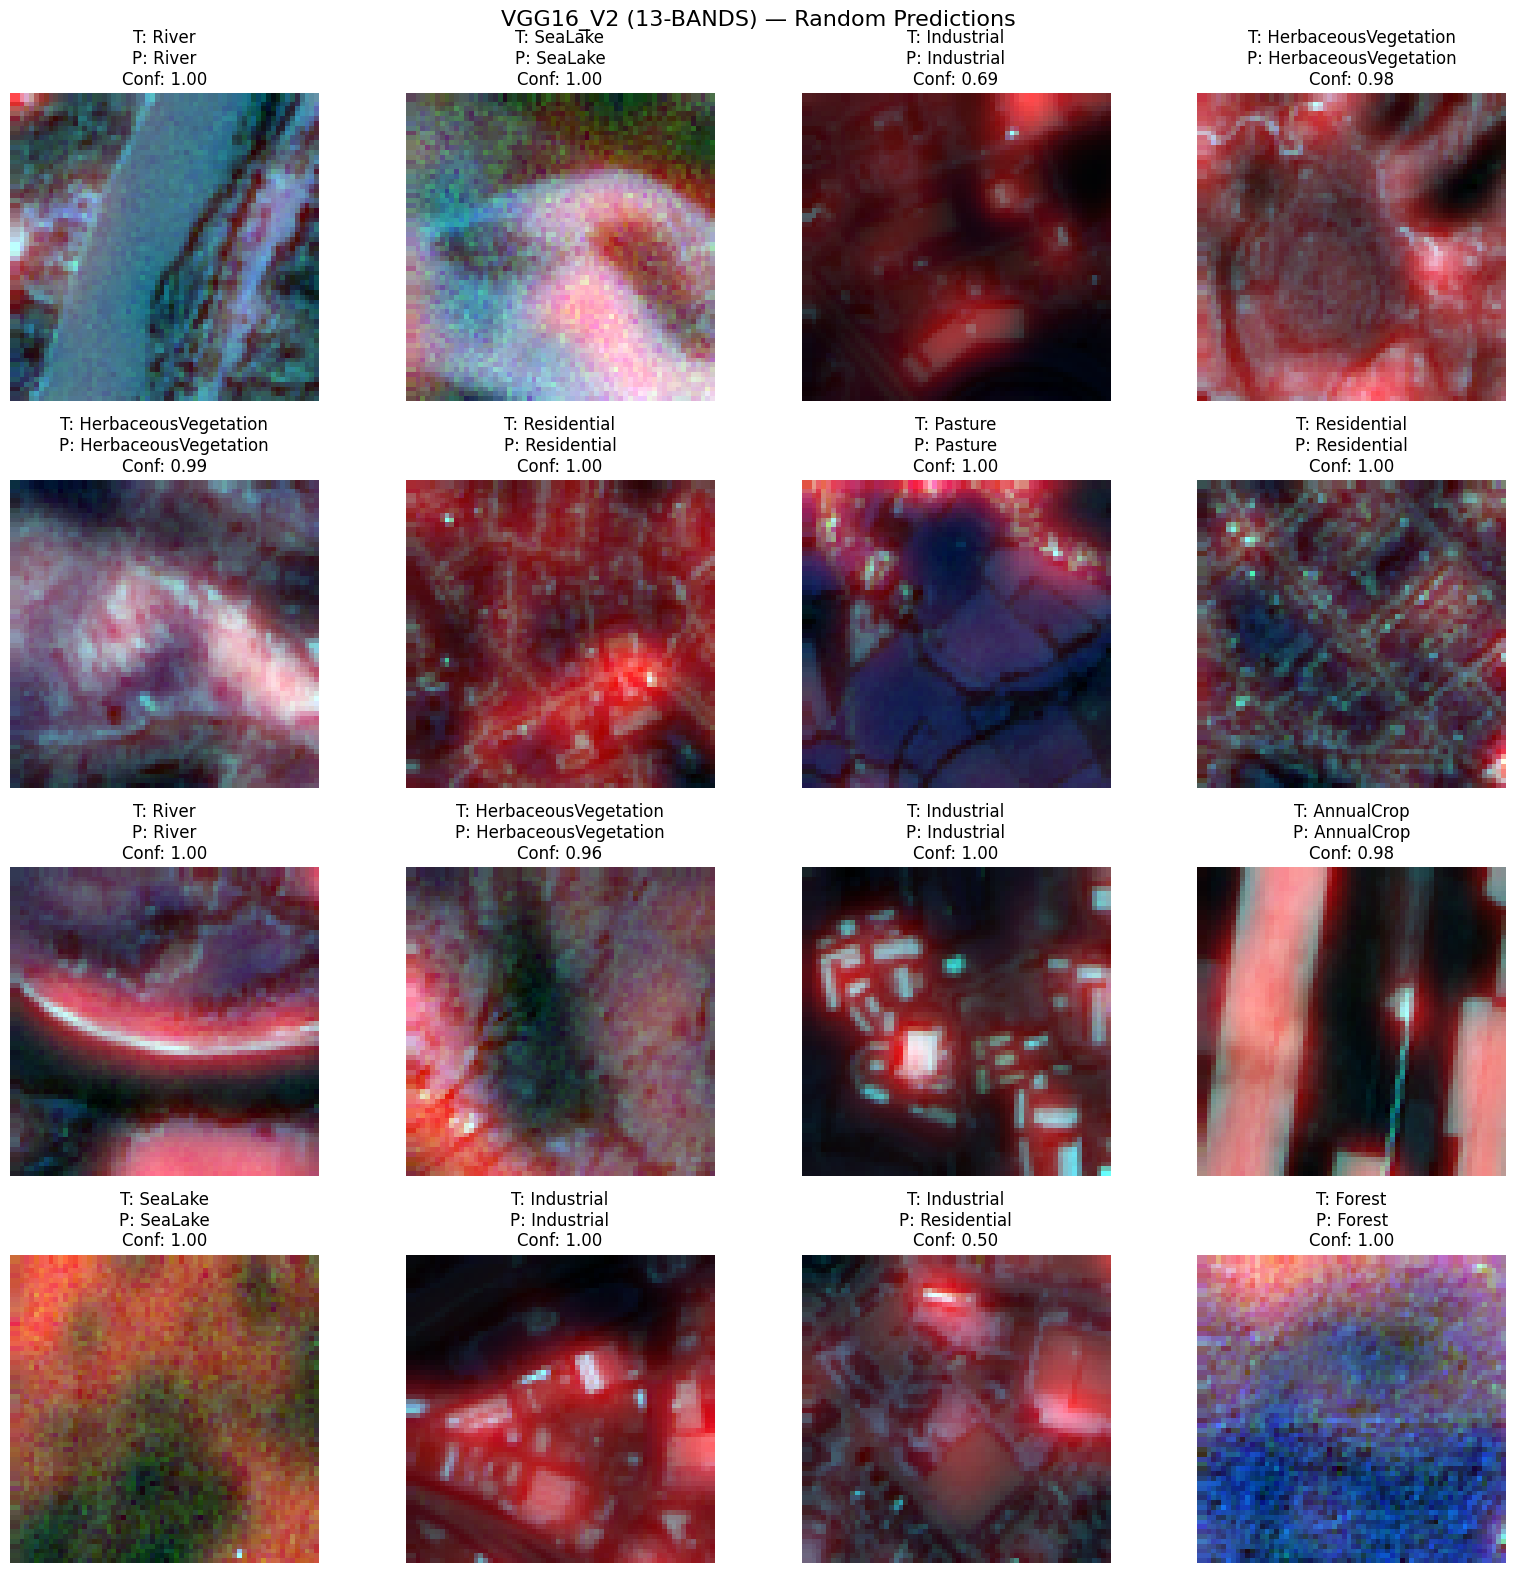

In [11]:
ACC_16_CNN, CI_16_CNN = show_random_predictions(
    CNN_V2_MODEL,
    "CNN_V2 (13-BANDS)",
    X_TEST,
    Y_TEST,
    CLASS_NAMES_V2,
    n_samples=16,
    seed=12
)

ACC_16_VGG, CI_16_VGG = show_random_predictions(
    VGG16_V2_MODEL,
    "VGG16_V2 (13-BANDS)",
    X_TEST,
    Y_TEST,
    CLASS_NAMES_V2,
    n_samples=16,
    seed=16
)


## 9. Bootstrapped Accuracy on 1000-Image Subsets

To measure robustness and stability,  
we perform **20 independent evaluation runs**:


In [9]:
NUM_RUNS = 20          
SAMPLE_SIZE = 1000     # sample size for each run

rng = np.random.default_rng(123) 

accs_cnn = []
accs_vgg = []

N_TEST = X_TEST.shape[0]

for run in range(NUM_RUNS):
    indices = rng.choice(N_TEST, size=SAMPLE_SIZE, replace=False)

    X_sub = X_TEST[indices]
    y_sub = Y_TEST[indices]

    # ---- CNN Predictions ----
    preds_cnn = CNN_V2_MODEL.predict(X_sub, verbose=0)
    y_pred_cnn = np.argmax(preds_cnn, axis=1)
    acc_cnn = accuracy_score(y_sub, y_pred_cnn)
    accs_cnn.append(acc_cnn)

    # ---- VGG Predictions ----
    preds_vgg = VGG16_V2_MODEL.predict(X_sub, verbose=0)
    y_pred_vgg = np.argmax(preds_vgg, axis=1)
    acc_vgg = accuracy_score(y_sub, y_pred_vgg)
    accs_vgg.append(acc_vgg)

    print(f"Run {run+1:02d} | CNN: {acc_cnn:.4f} | VGG: {acc_vgg:.4f}")


2025-11-30 02:53:06.889510: I external/local_xla/xla/service/service.cc:163] XLA service 0x7468380043b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-30 02:53:06.889745: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-30 02:53:07.091333: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-30 02:53:07.532147: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-30 02:53:07.717088: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-30 02:53:09.

Run 01 | CNN: 0.9230 | VGG: 0.9450
Run 02 | CNN: 0.9410 | VGG: 0.9460
Run 03 | CNN: 0.9250 | VGG: 0.9460
Run 04 | CNN: 0.9340 | VGG: 0.9470
Run 05 | CNN: 0.9290 | VGG: 0.9600
Run 06 | CNN: 0.9270 | VGG: 0.9540
Run 07 | CNN: 0.9210 | VGG: 0.9470
Run 08 | CNN: 0.9370 | VGG: 0.9460
Run 09 | CNN: 0.9140 | VGG: 0.9520
Run 10 | CNN: 0.9380 | VGG: 0.9470
Run 11 | CNN: 0.9240 | VGG: 0.9390
Run 12 | CNN: 0.9190 | VGG: 0.9420
Run 13 | CNN: 0.9350 | VGG: 0.9510
Run 14 | CNN: 0.9340 | VGG: 0.9550
Run 15 | CNN: 0.9180 | VGG: 0.9460
Run 16 | CNN: 0.9260 | VGG: 0.9360
Run 17 | CNN: 0.9250 | VGG: 0.9490
Run 18 | CNN: 0.9290 | VGG: 0.9550
Run 19 | CNN: 0.9260 | VGG: 0.9500
Run 20 | CNN: 0.9400 | VGG: 0.9510


## 10. Summary Statistics for Bootstrapped Accuracies

In [13]:
mean_cnn = np.mean(accs_cnn)
std_cnn  = np.std(accs_cnn, ddof=1)
ci_cnn   = accuracy_confidence_interval(mean_cnn, SAMPLE_SIZE)

mean_vgg = np.mean(accs_vgg)
std_vgg  = np.std(accs_vgg, ddof=1)
ci_vgg   = accuracy_confidence_interval(mean_vgg, SAMPLE_SIZE)

print("\n===== CNN_V2 (1000-sample) =====")
print(f"Mean accuracy: {mean_cnn:.4f}")
print(f"Std dev:       {std_cnn:.4f}")
print(f"95% CI:        [{ci_cnn[0]:.4f}, {ci_cnn[1]:.4f}]")

print("\n===== VGG16_V2 (1000-sample) =====")
print(f"Mean accuracy: {mean_vgg:.4f}")
print(f"Std dev:       {std_vgg:.4f}")
print(f"95% CI:        [{ci_vgg[0]:.4f}, {ci_vgg[1]:.4f}]")



===== CNN_V2 (1000-sample) =====
Mean accuracy: 0.9283
Std dev:       0.0076
95% CI:        [0.9123, 0.9442]

===== VGG16_V2 (1000-sample) =====
Mean accuracy: 0.9482
Std dev:       0.0056
95% CI:        [0.9345, 0.9619]


## 11. Accuracy Distribution Histograms


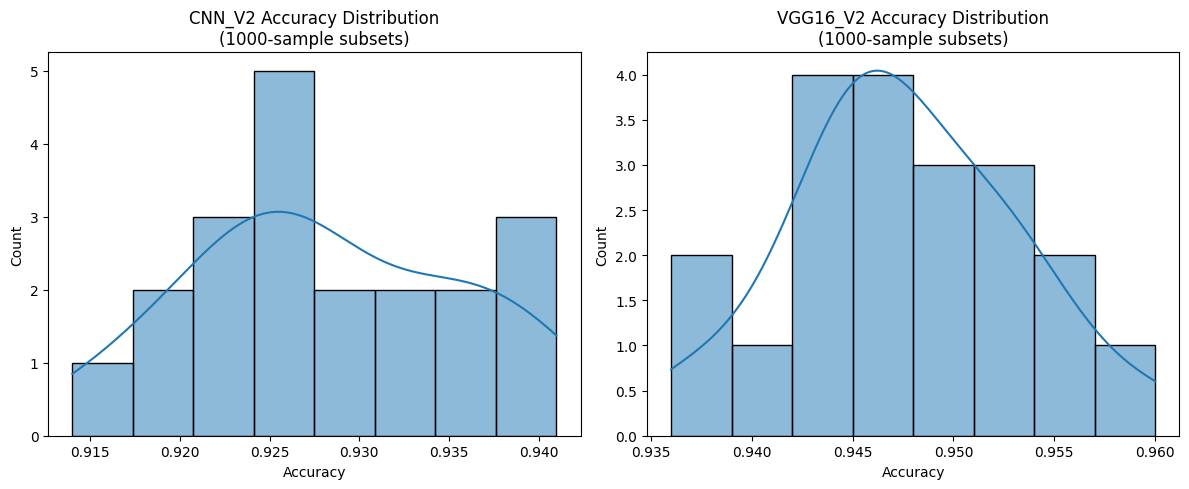

In [30]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(accs_cnn, bins=8, kde=True)
plt.title("CNN_V2 Accuracy Distribution\n(1000-sample subsets)")
plt.xlabel("Accuracy")
plt.ylabel("Count")

plt.subplot(1,2,2)
sns.histplot(accs_vgg, bins=8, kde=True)
plt.title("VGG16_V2 Accuracy Distribution\n(1000-sample subsets)")
plt.xlabel("Accuracy")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## Model Accuracy Comparison with 95% Confidence Intervals

/tmp/ipykernel_5012/2834675366.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


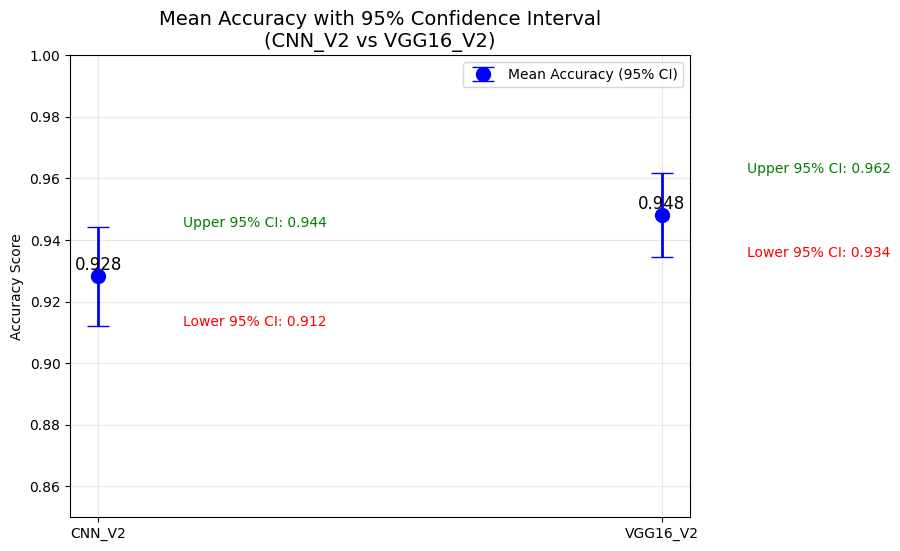

In [14]:
models = ["CNN_V2", "VGG16_V2"]

# MEANS
means = [mean_cnn, mean_vgg]

# LOWER & UPPER CI DISTANCES (error bar requires distance from mean)
lower_errors = [mean_cnn - ci_cnn[0], mean_vgg - ci_vgg[0]]
upper_errors = [ci_cnn[1] - mean_cnn, ci_vgg[1] - mean_vgg]

# Combine into asymmetric error bar format
errors = [lower_errors, upper_errors]

plt.figure(figsize=(8, 6))

plt.errorbar(
    models,
    means,
    yerr=errors,
    fmt='o',
    capsize=8,
    elinewidth=2,
    marker='o',
    markersize=10,
    color='blue',
    label="Mean Accuracy (95% CI)"
)

plt.title("Mean Accuracy with 95% Confidence Interval\n(CNN_V2 vs VGG16_V2)", fontsize=14)
plt.ylabel("Accuracy Score")
plt.ylim(0.85, 1.00)

# Annotate each point with value & CI
for i, model in enumerate(models):
    plt.text(i, means[i] + 0.002, f"{means[i]:.3f}", ha='center', fontsize=12)
    plt.text(i + 0.15, ci_cnn[1] if i==0 else ci_vgg[1],
             f"Upper 95% CI: { (ci_cnn[1] if i==0 else ci_vgg[1]):.3f}",
             color='green', fontsize=10)
    plt.text(i + 0.15, ci_cnn[0] if i==0 else ci_vgg[0],
             f"Lower 95% CI: { (ci_cnn[0] if i==0 else ci_vgg[0]):.3f}",
             color='red', fontsize=10)

plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Final Notes

This evaluation notebook demonstrates that:

- **VGG16_V2 consistently outperforms CNN_V2** on 13-band Sentinel-2 data.
- Both models achieve high test accuracy (>92%),  
  with VGG16_V2 reaching **~95%**.
- Bootstrapped sampling confirms that the models are **stable and robust**.
- Random visualization checks show that both models handle most land classes reliably.

This notebook contributes to:
- **Milestone 2** (Model Development & Training)  
- **Milestone 3** (Model Optimization & Evaluation)  

The next step would be **Milestone 4**, deploying the best model (VGG16_V2) in a Streamlit or Flask application for real-time land type classification.